<a href="https://www.kaggle.com/code/andrewbremner/weightrisk-s4e2-sklearn-models-vs-pytorch?scriptVersionId=162991384" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import time

from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


In [2]:
df = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')

# Explore Data

In [3]:
# No missing data
df.isnull().sum()

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [4]:
df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


### Check balance of data set

<Axes: xlabel='NObeyesdad', ylabel='count'>

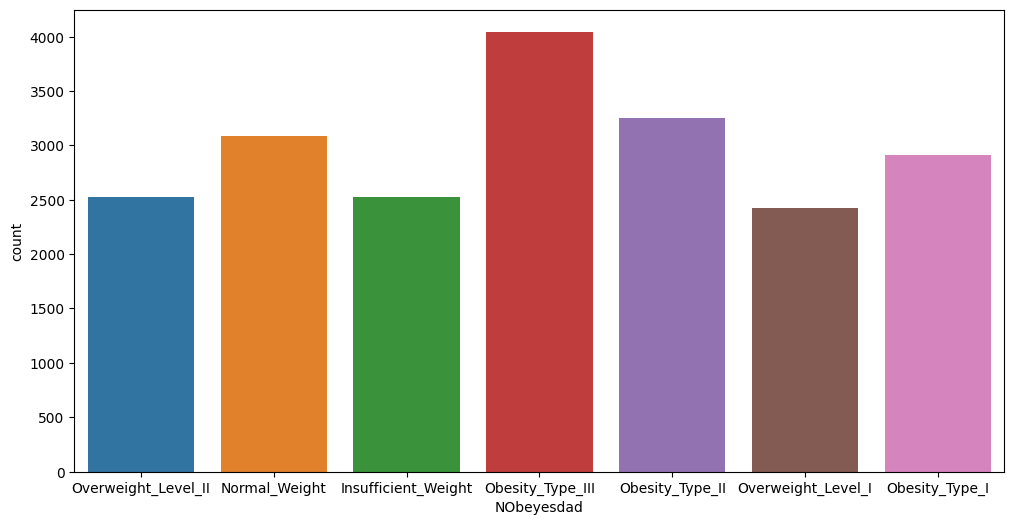

In [5]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='NObeyesdad')

### Pretty balenced dataset with a little larger weight to the higher obersity type III

In [6]:
catagorical_cols = ['Gender','family_history_with_overweight','FAVC','CAEC','SMOKE','SCC','CALC','MTRANS']
target_options = df['NObeyesdad'].unique()
ids = df['id']

### Cleaning data function (to dummy variables)
Make new column for BMI

In [7]:
def process_data_dummies(df):
    df = df.drop(['id'], axis=1)
    df = pd.get_dummies(df, drop_first=True)
    df['BMI'] = df['Weight'] /(df['Height']**2)
    return df

In [8]:
df_drop = df.drop(['NObeyesdad'], axis=1)
df_clean = process_data_dummies(df_drop)

In [9]:
df_clean

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,family_history_with_overweight_yes,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,BMI
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,True,True,...,False,False,False,True,False,False,False,True,False,28.259565
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,False,True,...,False,False,False,False,True,False,False,False,False,23.422091
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,False,True,...,False,False,False,False,True,False,False,True,False,17.126706
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,False,True,...,False,False,False,True,False,False,False,True,False,44.855798
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,True,True,...,False,False,False,True,False,False,False,True,False,25.599151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,25.137087,1.766626,114.187096,2.919584,3.000000,2.151809,1.330519,0.196680,True,True,...,False,False,False,True,False,False,False,True,False,36.587084
20754,18.000000,1.710000,50.000000,3.000000,4.000000,1.000000,2.000000,1.000000,True,False,...,False,False,False,True,False,False,False,True,False,17.099278
20755,20.101026,1.819557,105.580491,2.407817,3.000000,2.000000,1.158040,1.198439,True,True,...,False,False,False,False,True,False,False,True,False,31.889841
20756,33.852953,1.700000,83.520113,2.671238,1.971472,2.144838,0.000000,0.973834,True,True,...,False,False,False,False,True,False,False,False,False,28.899693


In [10]:
# # add BMI (weight (kg) / [height (m)]**2) units are correct
# df_clean['BMI'] = df_clean['Weight'] /(df_clean['Height']**2)

# Visualizations
**Map the string options to numbers for some visualizations**

In [11]:
target_map = {'Insufficient_Weight': 0,
              'Normal_Weight': 1,
              'Overweight_Level_I': 2,
              'Overweight_Level_II': 3,
              'Obesity_Type_I':4,
              'Obesity_Type_II': 5,
              'Obesity_Type_III': 6}
target_map_rev = {0:'Insufficient_Weight',
              1:'Normal_Weight',
              2:'Overweight_Level_I',
              3:'Overweight_Level_II',
              4:'Obesity_Type_I',
              5:'Obesity_Type_II',
              6:'Obesity_Type_III'}

In [12]:
df_clean['NObeyesdad'] = df['NObeyesdad'].map(target_map)

In [13]:
abs(df_clean.corr()['NObeyesdad']).sort_values(ascending=False)[1:]

BMI                                   0.961441
Weight                                0.921250
family_history_with_overweight_yes    0.522026
CAEC_Sometimes                        0.450950
CAEC_Frequently                       0.423351
Age                                   0.356211
CH2O                                  0.273154
FCVC                                  0.272933
CALC_Sometimes                        0.236984
FAF                                   0.234745
CALC_no                               0.226036
FAVC_yes                              0.215401
SCC_yes                               0.184959
Height                                0.150141
TUE                                   0.121009
MTRANS_Walking                        0.119828
CAEC_no                               0.076104
Gender_Male                           0.067699
MTRANS_Public_Transportation          0.062733
MTRANS_Motorbike                      0.028868
MTRANS_Bike                           0.028147
NCP          

### BMI is extremly correlated

<Axes: >

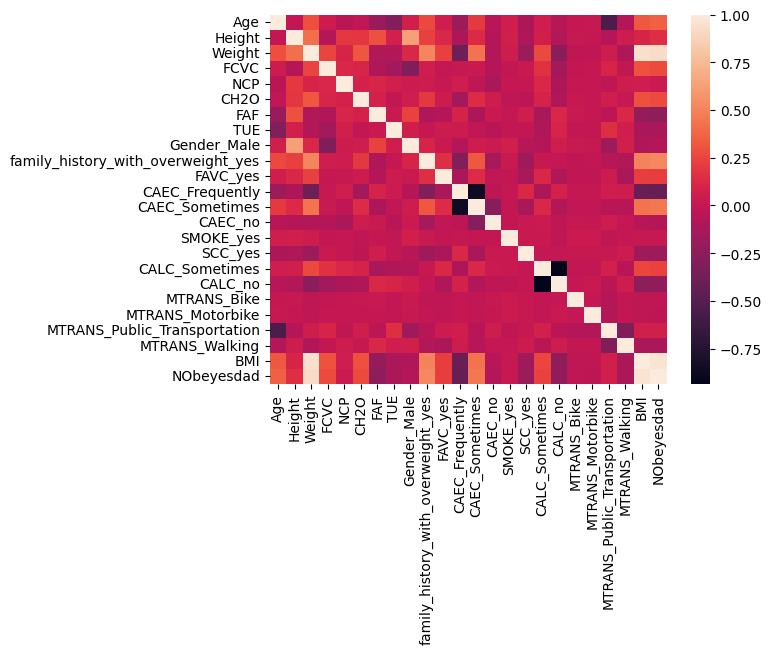

In [14]:
sns.heatmap(data=df_clean.corr())

# Train test split

In [15]:
# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Models
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

In [16]:
X = df_clean.drop(['NObeyesdad'],axis=1)
y = df['NObeyesdad']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=814)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Sci-Kit Learn Model tests

## Random Forest classifier

In [18]:
# rfc = RandomForestClassifier(n_estimators=100, class_weight="balanced")
# t1 = time.time()
# rfc.fit(X_train_scaled, y_train)
# total = time.time() - t1
# print(f'RFC took {total} s')
# rfc_pred = rfc.predict(X_test_scaled)
# print(f'RFC accuracy {round(accuracy_score(y_test, rfc_pred),8)}')

## Gradient Boosting Classifier 

In [19]:
# gbc = GradientBoostingClassifier(n_estimators=100)
# t1 = time.time()
# gbc.fit(X_train_scaled, y_train)
# total = time.time() - t1
# print(f'Final GBC took {total} s')
# gbc_pred = gbc.predict(X_test_scaled)
# print(f'GBC accuracy {round(accuracy_score(y_test, gbc_pred),8)}')

## Hist Gradient Boosting Classifier 

In [20]:
# hgbc = HistGradientBoostingClassifier(class_weight="balanced")
# t1 = time.time()
# hgbc.fit(X_train_scaled, y_train)
# total = time.time() - t1
# print(f'Final HGBC took {total} s')
# hgbc_pred = hgbc.predict(X_test_scaled)
# print(f'HGBC accuracy {round(accuracy_score(y_test, hgbc_pred),8)}')

# Retrain with all data with best model¶


### Final test data preparation

In [21]:
final_scaler = StandardScaler()
final_scaler.fit(X)
X_scaled = final_scaler.transform(X)
test_ids = df_test['id']
X_Final_test_clean = process_data_dummies(df_test)
X_Final_test_clean = X_Final_test_clean[X.columns] #issue with some data options not existing in train vs test
X_Final_test_clean_scaled = final_scaler.transform(X_Final_test_clean)

In [22]:
# # Final Train
# # final_model = RandomForestClassifier(n_estimators=100, class_weight="balanced")
# final_model = GradientBoostingClassifier(n_estimators=100)
# t1 = time.time()
# final_model.fit(X_scaled, y)
# total = time.time() - t1
# print(f'Final took {total} s')

In [23]:
# final_preds = final_model.predict(X_Final_test_clean_scaled)
# preds_df = pd.DataFrame(final_preds,columns=['NObeyesdad'])
# output_df = pd.concat([test_ids,preds_df],axis=1)

In [24]:
# output_df.to_csv('/kaggle/working/submission.csv', index=False)

# Neural Network (Pytorch)

In [25]:
df.dtypes

id                                  int64
Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

In [26]:
cont_cols = df.describe().columns
cont_cols = cont_cols.drop(['id'])
cat_cols_obj = df.dtypes[df.dtypes == 'object'].index
cat_cols = cat_cols_obj.drop('NObeyesdad')
y_col = ['NObeyesdad']

In [27]:
cont_cols, cat_cols

(Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object'),
 Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
        'SCC', 'CALC', 'MTRANS'],
       dtype='object'))

### Catagorical Data
Leaving as catagories even though they are mostly one hot encoded available

In [28]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [29]:
df[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Gender                          20758 non-null  category
 1   family_history_with_overweight  20758 non-null  category
 2   FAVC                            20758 non-null  category
 3   CAEC                            20758 non-null  category
 4   SMOKE                           20758 non-null  category
 5   SCC                             20758 non-null  category
 6   CALC                            20758 non-null  category
 7   MTRANS                          20758 non-null  category
dtypes: category(8)
memory usage: 163.4 KB


In [30]:
# Convert to numpy array the tensor for NN
cats = np.stack([df[col].cat.codes.values for col in cat_cols],axis=1)
cats = torch.tensor(cats, dtype=torch.int64)

In [31]:
cats

tensor([[1, 1, 1,  ..., 0, 1, 3],
        [0, 1, 1,  ..., 0, 2, 0],
        [0, 1, 1,  ..., 0, 2, 3],
        ...,
        [1, 1, 1,  ..., 0, 2, 3],
        [1, 1, 1,  ..., 0, 2, 0],
        [1, 1, 1,  ..., 0, 1, 3]])

### Continuous Data

In [32]:
# Convert to numpy array for NN
conts = np.stack([df[col].values for col in cont_cols],axis=1)
conts = torch.tensor(conts, dtype=torch.float)

In [33]:
conts

tensor([[ 24.4430,   1.7000,  81.6700,  ...,   2.7636,   0.0000,   0.9765],
        [ 18.0000,   1.5600,  57.0000,  ...,   2.0000,   1.0000,   1.0000],
        [ 18.0000,   1.7115,  50.1658,  ...,   1.9104,   0.8660,   1.6736],
        ...,
        [ 20.1010,   1.8196, 105.5805,  ...,   2.0000,   1.1580,   1.1984],
        [ 33.8530,   1.7000,  83.5201,  ...,   2.1448,   0.0000,   0.9738],
        [ 26.6804,   1.8165, 118.1349,  ...,   2.0036,   0.6845,   0.7138]])

## Label

In [34]:
df[y_col[0]].info()

<class 'pandas.core.series.Series'>
RangeIndex: 20758 entries, 0 to 20757
Series name: NObeyesdad
Non-Null Count  Dtype 
--------------  ----- 
20758 non-null  object
dtypes: object(1)
memory usage: 162.3+ KB


In [35]:
# set label as catagory
df[y_col[0]] = df[y_col[0]].astype('category')

In [36]:
df[y_col[0]].dtype

CategoricalDtype(categories=['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I',
                  'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I',
                  'Overweight_Level_II'],
, ordered=False, categories_dtype=object)

In [37]:
y = torch.tensor(df[y_col[0]].cat.codes, dtype=torch.int64)

In [38]:
len(y.unique())

7

# Model Class Creation

In [39]:
# Tabular model combined now
class TabluarModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p = 0.5):

        # layers = [200,100,50] FLEXIBLE!
        super().__init__()

        self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layerlist = []
        n_emb = sum([nf for ni,nf in emb_szs])
        n_in = n_emb + n_cont

        for i in layers:
#             layerlist.append(nn.ReLU())
            layerlist.append(nn.Linear(n_in,i))
#             layerlist.append(nn.LogSoftmax(dim=1))
#             layerlist.append(nn.GELU())
#             layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i

        layerlist.append(nn.Linear(layers[-1],out_sz))
#         layerlist.append(nn.Softmax(dim=1))

        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []

        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))

        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)

        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x,x_cont],1)
        x = self.layers(x)
        return x

## Define the training function

In [40]:
def train_model(model, cat, cont, y_true):
    start_time = time.time()
#     criterion = nn.CrossEntropyLoss() # Classification
    optimizer = torch.optim.Adam(model.parameters(),lr=0.05,weight_decay=0.0001)
    
    for i in range(epochs):
        i+=1

        y_pred = model(cat, cont)
        #loss = torch.sqrt(criterion(y_pred,y_train)) #Regression
        #print(y_pred)
        acc = metric(y_pred, y_true)
        acc_lst.append(acc)
        loss = criterion(y_pred, y_true) # Classification
        losses.append(loss)

        if i%50 == 1:
            print(f'epoch: {i:3} | loss: {loss.item():10.8f} | accuracy: {acc.item():10.8f}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    duration = time.time() - start_time
    print(f'Training took {duration/60} minutes')

In [41]:
for cat in cat_cols:
    df_test[cat] = df_test[cat].astype('category')

In [42]:
# Embeddings
cat_szs = [len(df_test[col].cat.categories) for col in cat_cols]
emb_szs = [(size,min(50,(size+1)//2)) for size in cat_szs]
emb_szs

[(2, 1), (2, 1), (2, 1), (4, 2), (2, 1), (2, 1), (4, 2), (5, 3)]

### Model Instance

In [43]:
model = TabluarModel(emb_szs = emb_szs, 
                     n_cont = conts.shape[1], 
                     out_sz = len(y.unique()), 
                     layers = [7],
                     p = 0.5)

In [44]:
model

TabluarModel(
  (embeds): ModuleList(
    (0-2): 3 x Embedding(2, 1)
    (3): Embedding(4, 2)
    (4-5): 2 x Embedding(2, 1)
    (6): Embedding(4, 2)
    (7): Embedding(5, 3)
  )
  (emb_drop): Dropout(p=0.5, inplace=False)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=7, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=7, out_features=7, bias=True)
  )
)

## Split data into train and testing

In [45]:
batch_size = int(len(df)*0.75)
test_size = len(df) - batch_size

In [46]:
test_size, batch_size

(5190, 15568)

In [47]:
cat_train = cats[:batch_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size]
con_test = conts[batch_size-test_size:batch_size]

y_train = y[:batch_size]
y_test = y[batch_size-test_size:batch_size]

In [48]:
len(y_test), len(y_train), len(y)

(5190, 15568, 20758)

In [49]:
y_train

tensor([6, 1, 0,  ..., 1, 5, 3])

## Criterion and Optimizer

In [50]:
criterion = nn.CrossEntropyLoss() # Classification
# optimizer = torch.optim.Adam(model.parameters(),lr=0.05,weight_decay=0.0001)

# Train model

In [51]:
epochs = 201
losses = []
acc_lst = []
metric = MulticlassAccuracy(num_classes = 7)

#run training
for i in (21,29,35,41,51,71,101):
    losses = []
    acc_lst = []
    model = TabluarModel(emb_szs = emb_szs, 
                         n_cont = conts.shape[1], 
                         out_sz = len(y.unique()), 
                         layers = [i],
                         p = 0.5)
    train_model(model, cat_train, con_train, y_train)
    model.eval()
    with torch.no_grad():
        y_val = model(cat_test, con_test)
        loss = criterion(y_val, y_test)
    y_val_out = [x.argmax().item() for x in y_val]
    print(str(i) + " ----")
    print(accuracy_score(y_test,y_val_out))
    print("-------------")

epoch:   1 | loss: 2.10373926 | accuracy: 0.17389713
epoch:  51 | loss: 0.58367693 | accuracy: 0.76144540
epoch: 101 | loss: 0.54796034 | accuracy: 0.79058814
epoch: 151 | loss: 0.53346521 | accuracy: 0.79179591
epoch: 201 | loss: 0.54671144 | accuracy: 0.79349411
Training took 0.10775498151779175 minutes
21 ----
0.8666666666666667
-------------
epoch:   1 | loss: 2.24968910 | accuracy: 0.11984275
epoch:  51 | loss: 0.52878278 | accuracy: 0.79925668
epoch: 101 | loss: 0.50993198 | accuracy: 0.80833381
epoch: 151 | loss: 0.49608612 | accuracy: 0.81326669
epoch: 201 | loss: 0.49566835 | accuracy: 0.81061697
Training took 0.10668302377065023 minutes
29 ----
0.8709055876685935
-------------
epoch:   1 | loss: 2.24004078 | accuracy: 0.13320623
epoch:  51 | loss: 0.52465624 | accuracy: 0.80137086
epoch: 101 | loss: 0.48765016 | accuracy: 0.82061142
epoch: 151 | loss: 0.47583330 | accuracy: 0.82811499
epoch: 201 | loss: 0.47035465 | accuracy: 0.82818383
Training took 0.11504034598668417 minut

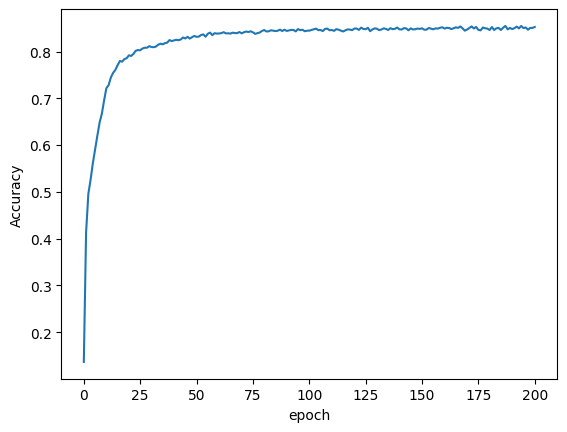

In [52]:
plt.plot(range(epochs), [x.item() for x in acc_lst])
plt.ylabel('Accuracy')
plt.xlabel('epoch');

# Validate the model

In [53]:
model.eval()
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)

In [54]:
y_val_out = [x.argmax().item() for x in y_val]

In [55]:
confusion_matrix(y_test,y_val_out)

array([[589,  43,   0,   0,   0,   3,   0],
       [ 58, 613,   1,   0,   0,  70,   7],
       [  0,   1, 599,  21,   5,  18,  50],
       [  0,   0,  19, 827,   3,   0,   6],
       [  1,   0,   1,   1, 976,   1,   0],
       [  2,  48,  12,   0,   0, 449, 107],
       [  0,   7,  61,   2,   0,  73, 516]])

In [56]:
accuracy_score(y_test,y_val_out)

0.8803468208092485

# Retrain with all data with model 

In [57]:
#reset model
model_final = TabluarModel(emb_szs = emb_szs, 
                     n_cont = conts.shape[1], 
                     out_sz = len(y.unique()), 
                     layers = [101],
                     p = 0.5)

In [58]:
model_final

TabluarModel(
  (embeds): ModuleList(
    (0-2): 3 x Embedding(2, 1)
    (3): Embedding(4, 2)
    (4-5): 2 x Embedding(2, 1)
    (6): Embedding(4, 2)
    (7): Embedding(5, 3)
  )
  (emb_drop): Dropout(p=0.5, inplace=False)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=101, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(101, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=101, out_features=7, bias=True)
  )
)

In [59]:
criterion = nn.CrossEntropyLoss() # Classification
optimizer = torch.optim.Adam(model_final.parameters(),lr=0.05,weight_decay=0.0001)

In [60]:
epochs = 201
losses = []
acc_lst = []
metric = MulticlassAccuracy(num_classes = 7)
#run training
train_model(model_final, cats, conts, y)

epoch:   1 | loss: 2.25936866 | accuracy: 0.13941440
epoch:  51 | loss: 0.45532611 | accuracy: 0.82876873
epoch: 101 | loss: 0.42053360 | accuracy: 0.84652668
epoch: 151 | loss: 0.41457233 | accuracy: 0.84612334
epoch: 201 | loss: 0.41033751 | accuracy: 0.84478533
Training took 0.18175389369328818 minutes


In [61]:
cat_cols,cont_cols

(Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
        'SCC', 'CALC', 'MTRANS'],
       dtype='object'),
 Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object'))

In [62]:
# for cat in cat_cols:
#     df_test[cat] = df_test[cat].astype('category')

# Convert to numpy array the tensor for NN
test_cats = np.stack([df_test[col].cat.codes.values for col in cat_cols],axis=1)
test_cats = torch.tensor(test_cats, dtype=torch.int64)
# Convert to numpy array for NN
test_conts = np.stack([df_test[col].values for col in cont_cols],axis=1)
test_conts = torch.tensor(test_conts, dtype=torch.float)

In [63]:
len(test_cats),len(test_conts)

(13840, 13840)

In [64]:
with torch.no_grad():
    y_val_final = model_final(test_cats, test_conts)

In [65]:
final_out = [x.argmax().item() for x in y_val_final]


In [66]:
sk_out = pd.DataFrame(final_out, columns=['SK_NObeyesdad'])

In [67]:
df_test['id']
pandas_tensor = pd.DataFrame(final_out, columns=['NObeyesdad'])
output_df = pd.concat([df_test['id'],pandas_tensor],axis=1)
output_df['NObeyesdad'] = output_df['NObeyesdad'].map(target_map_rev)
# output_df['SK_NObeyesdad'] = output_df['SK_NObeyesdad'].map(target_map_rev)
# output_df['match'] = output_df['NObeyesdad'] == output_df['SK_NObeyesdad']
output_df

,id,NObeyesdad
0,20758,Overweight_Level_II
1,20759,Obesity_Type_III
2,20760,Obesity_Type_I
3,20761,Overweight_Level_I
4,20762,Obesity_Type_I
...,...,...
13835,34593,Obesity_Type_III
13836,34594,Normal_Weight
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight


In [68]:
output_df.to_csv('/kaggle/working/submission.csv', index=False)